In [1]:
import numpy as np
from numpy.linalg import matrix_power, inv
from scipy.linalg import expm
from scipy.linalg import eig
from matplotlib.pyplot import *
import math
import random as rm
from numpy import sqrt,pi,e,cos,sin,tan
from scipy.optimize import minimize
from scipy import misc as ms
import time

In [3]:
def choose(n,r):
    f = math.factorial  
    return f(n) / f(r) / f(n-r)

def squoose(n,r):
    m = min(r, n-r)
    fm = math.factorial(m)
    prod = 1.
    for i in range(m):
        prod*= (n-i)/(float(m-i))
    return sqrt(prod)

#def comb(n,w,v,k):
#    return choose(w,k)*choose(n-w,v-k)*sqrt(1.*choose(n,w)/(choose(n,v+w-2*k)))

def trig(n,v,b):
    return (cos(b)**(n-v))*(1.0j*sin(b))**v
#def diffuse(n, fw, b):  # "applies the diffusion operator on a hamming symmetric state
#    out = (n+1)*[0.0+0.0j]
#    for w in range(n+1):
#        for v in range(n+1):
#            for k in range(max(0,v+w-n),min(v,w)+1):
#                out[w+v-2*k] += fw[w]*comb(n,w,v,k)*trig(n,v,b)
#    out = map(lambda x: x*e**(-1.0j*b*n),out)
#    return out
def symH0(n):
    H0 = n*np.identity(n+1)
    for i in range(n):
        H0[i,i+1] = -np.sqrt((i+1)*(n-i))
        H0[i+1,i] = -np.sqrt((i+1)*(n-i))
    return H0

def diffuse(n,fw,b):
    H0 = symH0(n)
    return np.dot(expm(-1.0j*b*H0),fw)
def diff0(n,fw,b):  # only compute the diffused amplitude at w=0. it's faster
    out=0
    for w in range(n+1):
        out+= fw[w]*trig(n,w,b)/squoose(n,w)
    return e**(-1.0j*b*n)*out
def merit(n,fw):
    a=2./2**(n)*sum(map(lambda w: fw[w]*squoose(n,w),range(n+1)))
    return 1.-np.abs(1.-a)**2                                     
def diffopt(n,f0,err,T):
    angles=[]
    anglesum=0
    f=f0
    for i in range(T):
        plot(f)
        p0=0.
        angle=0.
        while(p0<(i+1)*err):
            angle+=0.01
            b = anglesum+angle
            p0=np.real(1-diff0(n,f,angle))
        angles.append(angle)
        anglesum+=angle
        f=diffuse(n,f,angle)
        f[0] = 1-f[0]
        print(merit(n,f))
    show()
    return angles
def state0(n):
    tN = 1./2.**(n/2.)
    p   = np.zeros(n+1) # initialized probability vector in reduced basis
    seed = 1.
    for i in range(n+1):
        p[i] = seed # recursively produce N-choose-j (see next line)
        seed *= np.sqrt((n-i)/(i+1.))
    return tN*p # duplicates probabilities for z0=0 and 1
def costmatrix(n,m,dists,gamma):
    mat = np.diag([1.+0.j]*m*(n+1))
    wg = 1-e**(1.0j*gamma)
    print(wg)
    for i in range(m):
        for j in range(m):
            mat[i*(n+1),j*(n+1)+dists[i,j]] -= wg
    return mat
def mixmatrix(n,m,beta):
    return np.kron(np.identity(m),expm(-1.0j*beta*symH0(n)))
def success(n, dists, i, psi):
    amp = 0
    for j in range(m):
        amp+= psi[j*(n+1)+dists[i,j]]
    return abs(amp)**2/2**n

In [4]:
n=5
m=3
nor = np.kron(np.identity(m),np.diag([1./squoose(n,r) for r in range(n+1)]))
nori = np.kron(np.identity(m),np.diag([squoose(n,r) for r in range(n+1)]))
distances = np.array([[0,3,3],[3,0,2],[3,2,0]])
Bnor = nor@mixmatrix(n,m,np.pi/n)@nori
Cnor = costmatrix(n,m,distances,np.pi)
psi0 = np.array([1]*(n+1) + [0]*(m-1)*(n+1))
#psi1 = np.array([0]*(n+1)+[1]*(n+1) + [0]*(m-2)*(n+1))

(2-1.2246467991473532e-16j)


In [263]:
bc = Bnor@Cnor
def evolve(k,psi):
    return matrix_power(bc,k)@psi

In [264]:
p3 = [sum([success(n,distances,i,evolve(k,psi0)) for i in range(1)]) for k in range(500)]

In [261]:
p1= [success(n,distances,0,evolve(k,psi0)) for k in range(500)]

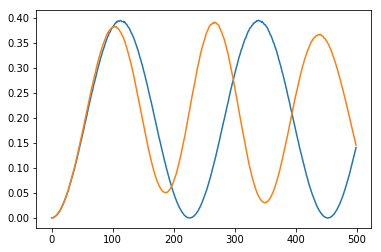

In [265]:
plot(p1); plot(p3); show()

In [31]:
n=10
m=3
nor = np.kron(np.identity(m),np.diag([1./squoose(n,r) for r in range(n+1)]))
nori = np.kron(np.identity(m),np.diag([squoose(n,r) for r in range(n+1)]))
distances = np.array([[0,7,4],[7,0,3],[4,3,0]])
Bnor = nor@mixmatrix(n,m,np.pi/n)@nori
Cnor = costmatrix(n,m,distances,np.pi)
psi0 = 1/m*2**(-n/2)*np.array([1]*(n+1)*m)# + [0]*(m-1)*(n+1))
freq = np.sqrt(m/(1<<n))
coeffs = []
for f in np.arange(0.0,1,0.001):
    fouri = np.identity(m*(n+1)) - e**(-2*pi*1.0j*(f-0.0001j))*Bnor*Cnor
    inverted = inv(fouri)@psi0
    coeffs.append(abs(inverted[11]))

(2-1.2246467991473532e-16j)


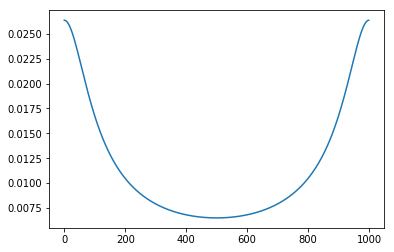

In [88]:
plot(coeffs); show()

In [32]:
BC = nori @ Bnor @ Cnor @ nor
val, vec = eig(BC)

In [34]:
list(map(np.arctan, np.imag(val)/np.real(val)))

[0.38500435020597984,
 0.3594791605762982,
 0.3510961913446332,
 -0.38500435020598095,
 -0.3594791605762977,
 -0.3510961913446345,
 1.070209717102396,
 1.1036889652471418,
 1.0922705248419766,
 -1.0702097171023968,
 -1.1036889652471429,
 -1.0922705248419766,
 -1.3359309313098906,
 -1.3493302974400911,
 -1.357040985621407,
 1.335930931309891,
 1.349330297440092,
 1.3570409856214078,
 -0.6418229067647676,
 -0.6873315555865386,
 -0.6787659472636353,
 0.6418229067647685,
 0.687331555586539,
 0.6787659472636359,
 -0.10065233760918002,
 -0.07565988540853077,
 0.10065233760918017,
 0.07565988540853101,
 -2.4576121667964396e-09,
 2.457611785198753e-09,
 4.639613803504973e-16,
 2.610758831345092e-16,
 1.413799632921098e-16]